# Explore

Environment Setup

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

pd.options.display.float_format = '{:20,.2f}'.format

import env
import explore

## Acquire

- mall_customers.customers from mysql database

In [2]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def get_mallcustomer_data():
    df = pd.read_sql('SELECT * FROM customers;', get_connection('mall_customers'))
    return df.set_index('customer_id')

df = get_mallcustomer_data()

In [3]:
df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


## Prepare

- Create dummy vars of 'gender' column, drop the first dummy var and keep remaining. 
- Because our target is continuous, I like to have a categorical representation in addition to the original in order to expand the ways we can explore. So below, we will create a categorical variable out of spending_score, for exploration purposes. 
- Split data into train, validate, and test. 
- Scale the continuous data.
- Dont scale target

In [5]:
def scale_my_data(train, validate, test):
    scaler = StandardScaler()
    scaler.fit(train[['age', 'annual_income']])
    X_train_scaled = scaler.transform(train[['age', 'annual_income']])
    X_validate_scaled = scaler.transform(validate[['age', 'annual_income']])
    X_test_scaled = scaler.transform(test[['age', 'annual_income']])

    train[['age_scaled', 'income_scaled']] = X_train_scaled
    validate[['age_scaled', 'income_scaled']] = X_validate_scaled
    test[['age_scaled', 'income_scaled']] = X_test_scaled
    
    return train, validate, test

def prep_mall(df):
    '''
    dummy var for gender into is_male
    add 'spending_class' that cut spending score into the 4 quartiles and label the new field by q1, q2, q3, q4. 
    split on target of 'spending_score'
    scale age and annual income. 
    '''
    df['is_male'] = pd.get_dummies(df['gender'], drop_first=True)['Male']
    df = df.drop(columns=['gender'])
    df['spending_class'] = pd.qcut(df.spending_score, q=4, labels=['q1', 'q2', 'q3', 'q4'])
    train, validate, test = explore.train_validate_test_split(df, target='spending_score', seed=123)
    train, validate, test = scale_my_data(train, validate, test)
        
    return df, train, validate, test


In [6]:
df, train, validate, test = prep_mall(df)

In [7]:
train.head()

,age,annual_income,spending_score,is_male,spending_class,age_scaled,income_scaled
customer_id,,,,,,,
124,39,69,91,1,q4,0.04,0.33
77,45,54,53,0,q3,0.45,-0.24
172,28,87,75,1,q4,-0.72,1.02
11,67,19,14,1,q1,1.97,-1.57
36,21,33,81,0,q4,-1.20,-1.04


## Explore

Steps: 

1. Univariate Standardized Exploration
2. Bivariate Standardized Exploration 
3. Multivariate Standardized Exploration
4. Customized Q&A Exploration 

Before exploration, I will create lists of variables to loop through in visualizing and testing. 
This looks a little different than when we had a binary target variable. 

- a list of binary variables
- a list of quantitative variables
- a variable holding the name of the continuous target variable
- a variable holding the name of the categorical target variable. 


In [8]:
binary_vars = ['is_male']
quant_vars = ['age', 'annual_income', 'spending_score']
categorical_target = 'spending_class'
continuous_target = 'spending_score'

### Univariate Exploration

Explore each individual variable on its own. This could also be done prior to splitting the data into train, validate and test. 

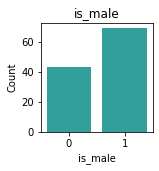

   is_male  Count              Percent
0        1     69                61.61
1        0     43                38.39
_________________________________________________________________


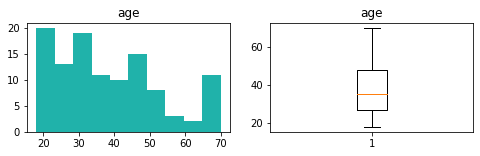

count                 112.00
mean                   38.42
std                    14.59
min                    18.00
25%                    27.00
50%                    35.50
75%                    48.00
max                    70.00
Name: age, dtype: float64


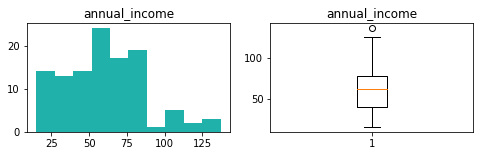

count                 112.00
mean                   60.25
std                    26.36
min                    15.00
25%                    40.00
50%                    61.50
75%                    77.25
max                   137.00
Name: annual_income, dtype: float64


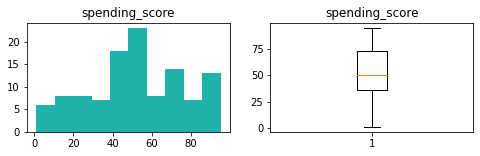

count                 112.00
mean                   52.04
std                    24.16
min                     1.00
25%                    35.75
50%                    50.00
75%                    73.25
max                    95.00
Name: spending_score, dtype: float64


In [9]:
explore.explore_univariate(train, binary_vars, quant_vars)

## Takeaways


- Spending score seems somewhat normally distributed. 
- Anual income from 15 to 137. I would. assume its in 1000s or Ks.
- 62 percent Male 38 percent Female. 
- Median age is 35

### Bivariate Exploration

is_male 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=1391.5, pvalue=0.5839845708203744)
                  chi2              p-value  degrees of freedom
0                 2.27                 0.52                   3

observed:
 spending_class  q1  q2  q3  q4  All
is_male                            
0               16  23  13  17   69
1                8  11  13  11   43
All             24  34  26  28  112

expected:
                      0                    1                    2  \
0                14.79                20.95                16.02   
1                 9.21                13.05                 9.98   

                     3  
0                17.25  
1                10.75  


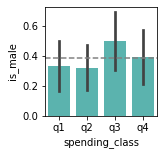


_____________________

age 
____________________



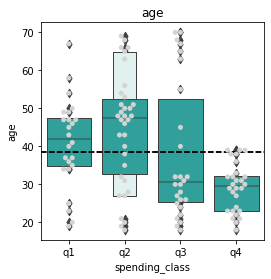

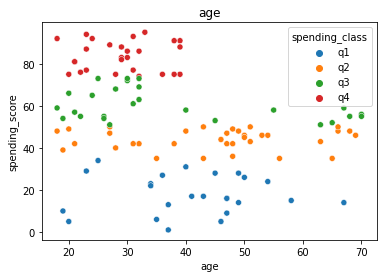

spending_class                   q1                   q2                   q3  \
count                         24.00                34.00                26.00   
mean                          40.96                44.62                37.92   
std                           11.78                14.81                18.19   
min                           19.00                18.00                18.00   
25%                           34.75                32.75                25.25   
50%                           42.00                47.50                30.50   
75%                           47.50                52.50                52.50   
max                           67.00                69.00                70.00   

spending_class                   q4  
count                         28.00  
mean                          29.18  
std                            6.32  
min                           18.00  
25%                           23.00  
50%                           29.50  
75% 

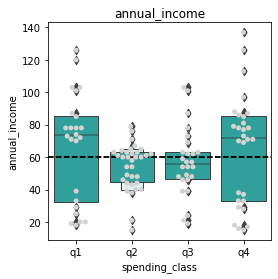

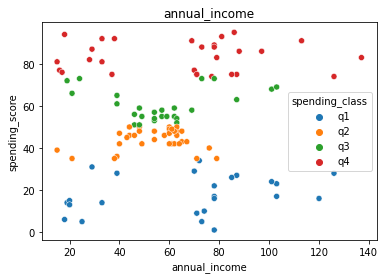

spending_class                   q1                   q2                   q3  \
count                         24.00                34.00                26.00   
mean                          66.67                54.21                56.73   
std                           33.39                14.04                20.87   
min                           18.00                15.00                19.00   
25%                           32.00                44.50                46.50   
50%                           73.50                60.00                55.50   
75%                           85.50                63.00                63.00   
max                          126.00                79.00               103.00   

spending_class                   q4  
count                         28.00  
mean                          65.36  
std                           33.79  
min                           15.00  
25%                           33.00  
50%                           72.00  
75% 

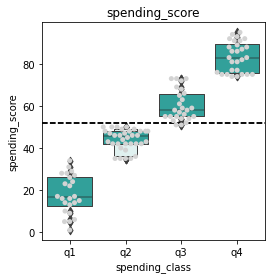

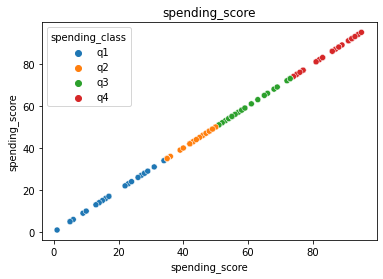

spending_class                   q1                   q2                   q3  \
count                         24.00                34.00                26.00   
mean                          17.92                44.06                60.19   
std                            9.23                 4.81                 7.34   
min                            1.00                35.00                51.00   
25%                           12.25                42.00                55.00   
50%                           16.50                45.50                58.00   
75%                           26.25                48.00                65.75   
max                           34.00                50.00                73.00   

spending_class                   q4  
count                         28.00  
mean                          83.39  
std                            7.16  
min                           74.00  
25%                           75.75  
50%                           83.00  
75% 

In [10]:
explore.explore_bivariate(train, categorical_target, continuous_target, binary_vars, quant_vars)

## Takeaways

- With a p-value of .52 there does not appear to be a significatn differance in spending score based on is_male.
- If shorter error bars on 2 and 3 you may want to compare 2 vs 3.
- Highest spending class made up of younger than 38, with the bulk being in 20s - 30s.
- As consumer ages past 40 or so the likelyhood of spoending score going above 60 drops.
- No one in q4 of spending socre is over 39
- Negativer correlation on spearmanscore (as age goes higher the spending score decreses) corr = -.367, pvalue = 6.6226 allows us to state this. 
- The outter edges of anual income lead to a spending score on the outer edges.
- e.g. those with low income could have a low or a highe spending score. similarly, those with high income, could have a low or high spending score The keyy is, there peeps dont usually sit in the middle when it comes to spending score.
- Good oppertunity of clusters of spending score by anual income. 5 clusters would be optimal.

### Multivariate Exploration

#### Standardized

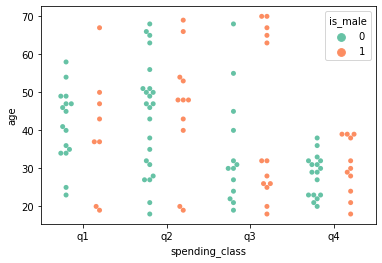

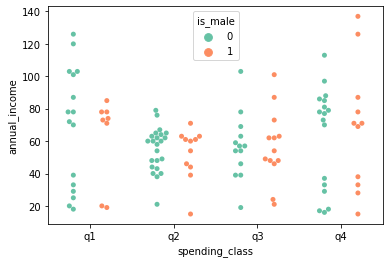

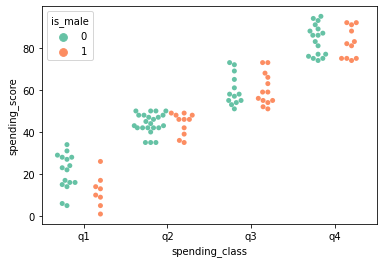

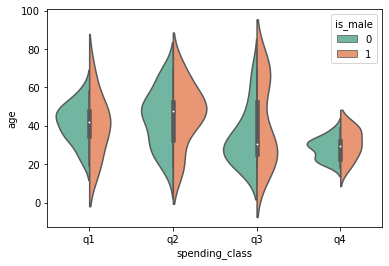

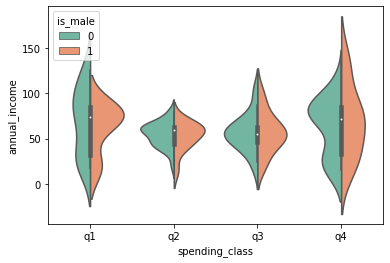

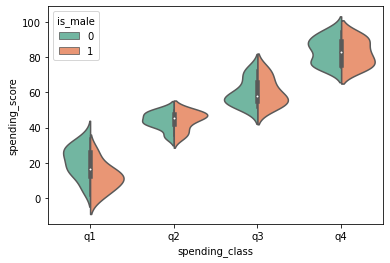

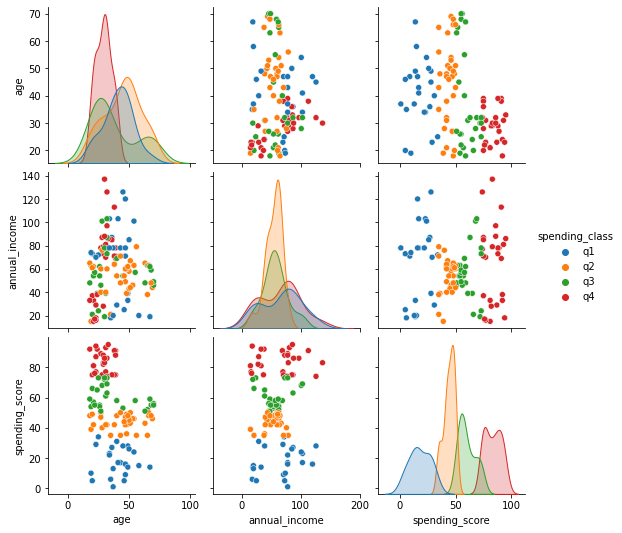

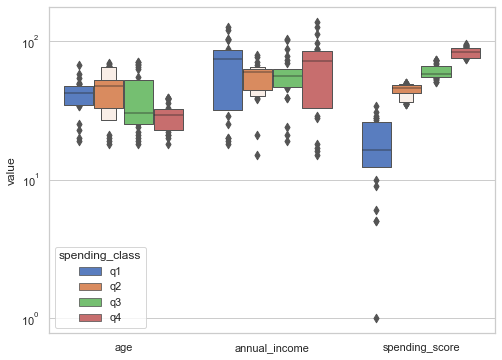

In [11]:
for var in binary_vars:
    explore.explore_multivariate(train, categorical_target, var, quant_vars)

## Takeaways

- males in q4 group are spread out more across age, while females have a larger spike. spending score might peak at a more specific, narrow age range.
- not much with respect to gender to add on to existing findings.

#### Question Driven

In [12]:
# What else can we answer or want to know?

-If we control for age, does spoending score differ across anual income?

Lets look at customers between 20 - 40

In [13]:
train.age.describe()

count                 112.00
mean                   38.42
std                    14.59
min                    18.00
25%                    27.00
50%                    35.50
75%                    48.00
max                    70.00
Name: age, dtype: float64

In [14]:
youngins = train[train.age < 40]

In [15]:
youngins.spending_class.value_counts()

q4    28
q3    17
q2    11
q1    10
Name: spending_class, dtype: int64

In [16]:
group1 = youngins[youngins.spending_class != 'q1']['annual_income']
group2 = youngins[youngins.spending_class == 'q4']['annual_income']

In [17]:
from scipy import stats

stats.mannwhitneyu(group1, group2, use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=697.5, pvalue=0.41430048281431275)

- There does not appear to be a significant difference in annual income for those less that 40 with top sopending scor and the bottom spending score groups.

Does spending score differ across gender for the younger group?

In [19]:
group1 = youngins[youngins.is_male == 1]['spending_score']
group2 = youngins[youngins.is_male == 0]['spending_score']

stats.mannwhitneyu(group1, group2)

MannwhitneyuResult(statistic=495.5, pvalue=0.41363272310880744)

- There seems to be no significant difference between spending scores across age.